In [1]:
import numpy as np
import pandas as pd
import os
import dlib
import cv2
from skimage.io import imshow
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfms
from PIL import Image

In [2]:
import cv2
import os
import numpy as np
import random
import argparse
import pandas as pd
from tqdm import tqdm

SEED = 10
random.seed(SEED)
np.random.seed(SEED)

# Dataset Parameters
img_size = 224
size = 15
question_size = 10 # 6 for one-hot vector of color, 1 for question type, 3 for question subtype
q_type_idx = 6
sub_q_type_idx = 7
nb_questions = 10
# Possibles Answers : [yes, no, rectangle, circle, 1, 2, 3, 4, 5, 6]

colors = [
    (0,0,255), # red
    (0,255,0), # green
    (255,0,0), # blue
    (0,156,255), # orange
    (128,128,128), # gray
    (0,255,255) # yellow
]

def center_generate(objects):
    '''Generate centers of objects'''
    while True:
        pas = True
        center = np.random.randint(0+size, img_size - size, 2)        
        if len(objects) > 0:
            for name, c, shape, _ in objects:
                if ((center - c) ** 2).sum() < ((size * 2) ** 2):
                    pas = False
        if pas:
            return center


def build_sample():
    '''Returns an image (with its bbox and attributes) and the corresponding questions, programs and answers'''
    
    # Create objects
    objects = [] # [(color, center, shape, xmin, ymin, xmax, ymax), (...), ...]
    img = np.ones((img_size,img_size,3)) * 255
    for color_id, color in enumerate(colors):  
        center = center_generate(objects)
        if random.random()<0.5:
            start = (center[0]-size, center[1]-size)
            end = (center[0]+size, center[1]+size)
            cv2.rectangle(img, start, end, color, -1)
            objects.append((color_id, center, 'r', (start[0], start[1], end[0], end[1]))) 
        else:
            start = (center[0]-size, center[1]-size)
            end = (center[0]+size, center[1]+size)
            center_ = (center[0], center[1])
            cv2.circle(img, center_, size, color, -1)
            objects.append((color_id, center, 'c', (start[0], start[1], end[0], end[1])))


    rel_questions = []
    norel_questions = []
    rel_answers = []
    norel_answers = []
    
    # Non-Relational Questions
    for _ in range(nb_questions):
        
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[q_type_idx] = 0
        subtype = random.randint(0,2)
        question[subtype+sub_q_type_idx] = 1
        norel_questions.append(question)
        
        if subtype == 0:
            # query shape -> rectangle/circle
            if objects[color][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 1:
            # query is left side (horizontal position) -> yes/no
            if objects[color][1][0] < img_size / 2:
                answer = 0
            else:
                answer = 1

        elif subtype == 2:
            # query is up side (vertical position) -> yes/no
            if objects[color][1][1] < img_size / 2:
                answer = 0
            else:
                answer = 1
        norel_answers.append(answer)
    
    # Relational Questions
    for _ in range(nb_questions):
        
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[q_type_idx] = 1
        subtype = random.randint(0,2)
        question[subtype+sub_q_type_idx] = 1
        rel_questions.append(question)

        if subtype == 0:
            # closest to -> rectangle/circle
            my_obj = objects[color][1]
            distances = np.array([np.linalg.norm(np.array(my_obj) - np.array(obj[1])) for obj in objects])
            sorted_dists = distances.argsort()
            idx = sorted_dists[0] if distances[sorted_dists[0]] != 0 else sorted_dists[1]
#             dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
#             dist_list[dist_list.index(0)] = 999
#             closest = dist_list.index(min(dist_list))
            if objects[idx][2] == 'r':
                answer = 2
            else:
                answer = 3
                
        elif subtype == 1:
            # furthest from -> rectangle/circle
            my_obj = objects[color][1]
            distances = np.array([np.linalg.norm(np.array(my_obj) - np.array(obj[1])) for obj in objects])
            sorted_dists = distances.argsort()
            idx = sorted_dists[-1] if distances[sorted_dists[-1]] != 0 else sorted_dists[-2]
#             dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
#             furthest = dist_list.index(max(dist_list))
            if objects[idx][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 2:
            # count -> 1~6
            my_obj = objects[color][2]
            count = -1
            for obj in objects:
                if obj[2] == my_obj:
                    count += 1 
            answer = count + 4

        rel_answers.append(answer)

    relations = (rel_questions, rel_answers)
    norelations = (norel_questions, norel_answers)
    img = img / 255.
    sample = (img, objects, relations, norelations)
    
    return sample

def convert_sample(sample):
    '''Converts question/answer vector to natural language questions and programs'''
    
    img, objects, (rel_questions, rel_answers), (norel_questions, norel_answers) = sample
    colors = ['red', 'green', 'blue', 'orange', 'gray', 'yellow']
    answer_sheet = ['yes', 'no', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6']
    questions = rel_questions + norel_questions
    answers = rel_answers + norel_answers
    
    queries = []
    programs = []
    text_answers = []

    for i, (question, answer) in enumerate(zip(questions, answers)):
        query = f'Q{i}. '
        color = colors[question.tolist()[0:6].index(1)]
        
        # Non-relational questions
        if question[q_type_idx] == 0:
            if question[sub_q_type_idx] == 1:
                queries.append(f'What is the shape of the {color} object?')
                programs.append(f'filter {color} <nxt> query shape')
                
            elif question[sub_q_type_idx+1] == 1:
                queries.append(f'Is there a {color} object on the left?')
                programs.append(f'filter {color} <nxt> query position <nxt> isLeft')
                
            elif question[sub_q_type_idx+2] == 1:
                queries.append(f'Is there a {color} object on the top?')
                programs.append(f'filter {color} <nxt> query position <nxt> isTop')
            
        # Relational questions
        elif question[q_type_idx] == 1:
            if question[sub_q_type_idx] == 1:
                queries.append(f'What is the closest shape to the {color} object?')
                programs.append(f'filter {color} <nxt> relate closest <nxt> query shape')
                
            elif question[sub_q_type_idx+1] == 1:
                queries.append(f'What is the furthest shape from the {color} object?')
                programs.append(f'filter {color} <nxt> relate furthest <nxt> query shape')
                
            elif question[sub_q_type_idx+2] == 1:
                queries.append(f'How many objects of the same shape as the {color} object are there?')
                programs.append(f'filter {color} <nxt> query shape <nxt> filter <nxt> count')
        
        ans = answer_sheet[answer]
        text_answers.append(ans)
        
    return img, objects, queries, programs, text_answers


In [3]:
# Generate a sample i.e.
# a tuple of 1 image, 6 objects' properties, 20 QA vectors (10 relational and 10 non-relational)
sample = build_sample()

In [4]:
# Break down the sample
img, objects, queries, programs, answers = convert_sample(sample)

In [5]:
img = (img * 255).astype('uint8')

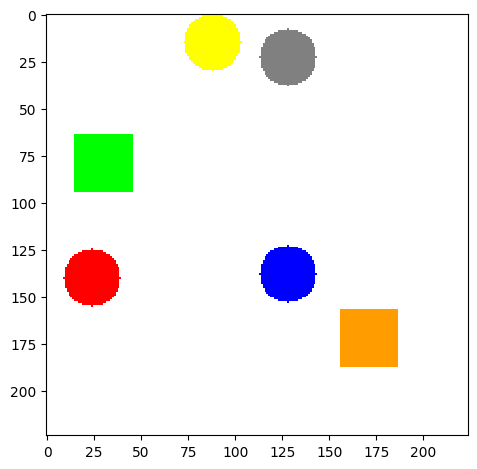

In [6]:
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
objects

[(0, array([ 24, 140]), 'c', (9, 125, 39, 155)),
 (1, array([30, 79]), 'r', (15, 64, 45, 94)),
 (2, array([128, 138]), 'c', (113, 123, 143, 153)),
 (3, array([171, 172]), 'r', (156, 157, 186, 187)),
 (4, array([128,  23]), 'c', (113, 8, 143, 38)),
 (5, array([88, 15]), 'c', (73, 0, 103, 30))]

In [8]:
def build_dataset(num_samples, data_dir, prefix='train'):
    '''Builds a Full Dataset with Images, Detector Data, Attribute Data, Queries, Programs and Answers'''
    
    # Generate Samples
    samples = [build_sample() for _ in range(num_samples)]
    
    # Init dataframes
    img_det_df = pd.DataFrame(columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    que2prog_df = pd.DataFrame(columns=['filename', 'answer', 'query_text', 'program_text'])
    
    img_dir = os.path.join(data_dir, 'images')
    shape_map = {'r': 'rectangle', 'c': 'circle'}
    
    try:
        os.makedirs(data_dir)
    except:
        pass
    
    try:
        os.makedirs(img_dir)
    except:
        pass
    
    for i, sample in enumerate(tqdm(samples)):
        # Get Data
        img, objects, queries, programs, answers = convert_sample(sample)
        
        # Save Image
        filename = f'{i}.jpg'
        img_path = os.path.join(img_dir, filename)
        cv2.imwrite(img_path, img * 255)
        
        # Append image data to dataframes
        for obj in objects:
            # Get object params
            color_id, shape, bbox = obj[0], shape_map[obj[2]], obj[3]
            
            img_det_df = img_det_df.append({'filename': filename, 
                                            'width': img_size, 
                                            'height': img_size, 
                                            'class': 'obj', 
                                            'xmin': bbox[0], 'ymin': bbox[1],
                                            'xmax': bbox[2], 'ymax': bbox[3]}, ignore_index=True)
        
        # Append text data to dataframe
        for answer, query, program in zip(answers, queries, programs):
            que2prog_df = que2prog_df.append({'filename': filename,
                                              'answer': answer,
                                              'query_text': query,
                                              'program_text': program}, ignore_index=True)
    
    # Save to csv files
    img_det_df.to_csv(os.path.join(data_dir, f'{prefix}_img_det.csv'), index=False)
    que2prog_df.to_csv(os.path.join(data_dir, f'{prefix}_q2p.csv'), index=False)

In [9]:
# Generate the dataset
n_train_imgs = 100
n_test_imgs = 10

build_dataset(n_train_imgs, data_dir='data/train', prefix='train')
build_dataset(n_test_imgs, data_dir='data/test', prefix='test')

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
def load_image_data(csv_file, img_dir):
    '''Load the image detection data for training the object detector'''
    # Annotations
    annot = pd.read_csv(csv_file)
    
    data = {}
    for i in range(len(os.listdir(img_dir))):
        # Get all rows belonging to the same scene
        scene = annot[annot['filename'] == f'{i}.jpg']
        # Read the image
        img = cv2.imread(os.path.join(img_dir, f'{i}.jpg'))
        
        # Add bounding box information for dlib
        bboxes = []
        for row in scene.values:
            x1, y1, x2, y2 = row[-4:]
            dlib_box = dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2)
            bboxes.append(dlib_box)
        
        data[i] = (img, bboxes)
    
    return data

In [10]:
# Load the Image Detection Data
det_data = load_image_data('data/train/train_img_det.csv', 'data/train/images')

NameError: name 'load_image_data' is not defined

In [11]:
det_data[4][1]

NameError: name 'det_data' is not defined

In [12]:
import numpy as np
import pandas as pd
import os
import dlib
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfms
from PIL import Image
from tqdm.notebook import tqdm


def train_detector(train_data, filename='detector.svm'):
    '''Trains an object detector (HOG + SVM) and saves the model'''
    
    # Seperate the images and bounding boxes in different lists.
    images = [val[0] for val in train_data.values()]
    bounding_boxes = [val[1] for val in train_data.values()]
    
    # Initialize object detector Options
    options = dlib.simple_object_detector_training_options()
    options.add_left_right_image_flips = False
    options.C = 5
    
    # Train the model
    detector = dlib.train_simple_object_detector(images, bounding_boxes, options)
    
    # Check results
    results = dlib.test_simple_object_detector(images, bounding_boxes, detector)
    print(f'Training Results: {results}')
    
    # Save model
    detector.save(filename)
    print(f'Saved the model to {filename}')

In [13]:
%%time
# Train the Model
train_detector(det_data, 'detector.svm')

NameError: name 'det_data' is not defined

In [ ]:
class Binarize():
    '''PyTorch Transforms Object'''
    def __init__(self):
        '''Converts Grayscale to Binary (except white every other color is zeroed)'''
        pass
    
    def __call__(self, img_tensor):
        '''
        Args:
            img_tensor (tensor): 0-1 scaled tensor with 1 channel
        Returns:
            tensor
        '''
        return (img_tensor > 0.95).float()

In [ ]:
# Load the images
shapes_data = ImageFolder('data/shapes_data/', transform=tfms.Compose([tfms.Grayscale(), 
                                                                       tfms.Resize((40, 40)), 
                                                                       tfms.ToTensor(),
                                                                       Binarize()]))

In [ ]:
shapes_data.class_to_idx

{'circle': 0, 'rectangle': 1}

In [ ]:
# Create the dataloader
shapes_loader = DataLoader(shapes_data, batch_size=20, shuffle=True)

In [ ]:
class ShapeClassifier(nn.Module):
    '''Simple CNN based Image Classifier for Shapes (circle | rectangle)'''
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 28, 3, stride=2, padding=1),
                                  nn.BatchNorm2d(28),
                                  nn.Conv2d(28, 28, 3, stride=2, padding=1),
                                  nn.BatchNorm2d(28),
                                  nn.Conv2d(28, 28, 3, stride=2, padding=1),
                                  nn.BatchNorm2d(28))
        self.fc = nn.Linear(700, 1)
    
    def forward(self, x):
        '''Forward Pass'''
        # batch_size (N)
        N = x.size()[0]
        # Extract features with CNN
        x = self.conv(x)
        # Classifier head
        x = self.fc(x.reshape(N, -1))
        
        return x
    
    def train_classifier(self, train_loader, lr=0.0001, epochs=10, filename='classifier.pth', device=None):
        '''Train the shape classifier'''
        # Automatically set device if not provided
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Mount to device
        self.to(device)
        
        # Create optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()
        
        self.train()
        # Start Training
        for epoch in range(epochs):
            pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
            losses = []
            
            for i, (image, label) in enumerate(train_loader):
                # Mount to device
                image, label = image.to(device).float(), label.to(device)
                
                # Forward prop
                out = self(image)
                
                # Loss
                loss = criterion(out.squeeze(1), label.float())
                
                # Backprop and Optimization
                loss.backward()
                optimizer.step()
                
                # Verbose
                losses.append(loss.item())
                pbar.update(1)
                pbar.set_postfix({'Loss': loss.item()})
            
            print(f'Epoch {epoch+1}: Mean Loss = {sum(losses)/len(losses)}')
            pbar.close()
            
        # Save model
        torch.save(self.state_dict(), filename)

In [ ]:
# Model
shape_classifier = ShapeClassifier()

In [ ]:
# Train
shape_classifier.train_classifier(shapes_loader, lr=0.0001, epochs=50, filename='classifier.pth')

In [ ]:
class PerceptionPipe():
    '''
    Full Perception Pipeline i.e.
    detector -> attribute extraction -> structural scene representation
    '''
    def __init__(self, detector_file, classifer_file, device='cpu'):
        # Object detector
        self.detector = dlib.simple_object_detector(detector_file)
        
        # Shape Classifier
        self.classifier = ShapeClassifier().to(device)
        self.classifier.load_state_dict(torch.load(classifer_file))
        self.device = device
        
        self.colors = np.array([[0,0,255], [0,255,0], [255,0,0], 
                               [0,156,255], [128,128,128], [0,255,255]])
        
        self.idx2color = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'gray', 5: 'yellow'}
        self.preproc = tfms.Compose([tfms.Grayscale(),
                                     tfms.Resize((40, 40)),
                                     tfms.ToTensor(),
                                     Binarize()])
    
    
    def detect(self, img):
        '''Detects and Returns Objects and its centers'''
        # Detect
        detections = self.detector(img)
        objects = []
        
        for detection in detections:
            # Get the bbox coords
            x1, y1 = int(detection.left()), int(detection.top())
            x2, y2 = int(detection.right()), int(detection.bottom())
            
            # Clip negative values to zero
            x1, y1, x2, y2 = np.array([x1, y1, x2, y2]).clip(min=0).tolist()

            # Find the center
            center = (int((x1+x2)/2), int((y1+y2)/2))

            # Crop the individual object
            obj = img[y1:y2, x1:x2]

            objects.append((obj, center))
            
        return objects
    
    
    def extract_attributes(self, x_img, prob=0.5, debug=False):
        '''Returns the shape and color of a given object'''
        # Load image as PIL instance (color image)
        image = Image.fromarray(cv2.cvtColor(x_img, cv2.COLOR_BGR2RGB))
        # Preprocess (binarized image)
        img = self.preproc(image).unsqueeze(0).to(self.device)
        
        # Predict Shape
        with torch.no_grad():
            out = torch.sigmoid(self.classifier(img)).squeeze()
            if debug:
                print(out)
        if out < prob:
            shape = 'circle'
        else:
            shape = 'rectangle'
            
        # Extract Color
        center_pixel = (x_img[20, 20, :]).astype('int')
        
        color_id = cosine_similarity(center_pixel.reshape(1, -1), self.colors).argmax()
        color = self.idx2color[color_id]
        
#         print(center_pixel)
#         print(color_id)
        
        return shape, color
    
    def scene_repr(self, img, prob=0.5, debug=False):
        '''Returns a structured scene representation as a dataframe'''
        # Perform object detection and get the objects
        objects = self.detect(img)
        
        # Init Scene representation
        scene_df = pd.DataFrame(columns=['shape', 'color', 'position'])
        
        for obj, center in objects:
            shape, color = self.extract_attributes(obj, prob, debug)
            scene_df = scene_df.append({'shape': shape, 
                                        'color': color, 
                                        'position': center}, ignore_index=True)
        
        return scene_df

In [ ]:
# Load the Model
perceiver = PerceptionPipe('detector.svm', 'classifier.pth', device='cuda')

In [ ]:
# Inference with Detector
objects = perceiver.detect(img)

In [ ]:
len(objects[0])

2

In [ ]:
# Inference with Attribute Extractor (Shape Classifier, Color Extractor)
shape, color = perceiver.extract_attributes(objects[3][0])
print(f'Shape = {shape}\nColor = {color}')

Shape = circle
Color = blue


In [ ]:
scene = perceiver.scene_repr(img)
scene

/tmp/ipykernel_8862/1678006832.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/tmp/ipykernel_8862/1678006832.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/tmp/ipykernel_8862/1678006832.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/tmp/ipykernel_8862/1678006832.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/tmp/ipykernel_8862/1678006832.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

,shape,color,position
0,rectangle,orange,"(171, 172)"
1,circle,red,"(23, 140)"
2,circle,gray,"(127, 20)"
3,circle,blue,"(127, 136)"
4,rectangle,green,"(31, 80)"
5,circle,yellow,"(87, 17)"


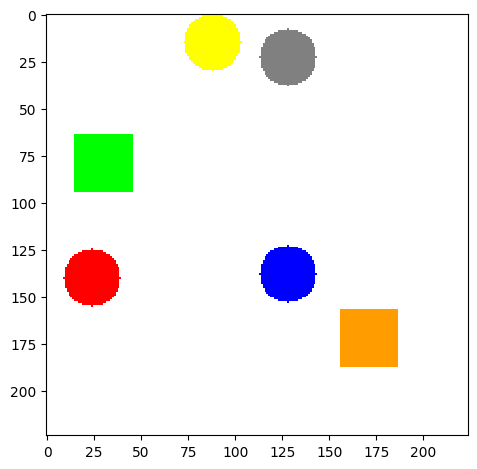

In [ ]:
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
from torchtext.data import BucketIterator

In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
from torch import nn
from torchtext.data import Field, TabularDataset, BucketIterator
import spacy
from tqdm.notebook import tqdm

class Preprocessor():
    '''Preprocessor for preparing Queries and Programs for Seq2Seq'''
    def __init__(self, train_csv):
        self.spacy_en = spacy.load("en_core_web_sm")
        
        # Create fields
        self.que_f = Field(tokenize=self.tokenizer, use_vocab=True, init_token="<sos>", eos_token="<eos>", lower=True)
        self.prog_f = Field(tokenize=self.tokenizer, use_vocab=True, init_token="<sos>", eos_token="<eos>", lower=True)
        
        # Preprocess
        self.train_data = self.preprocess(train_csv)
        
    def tokenizer(self, text):
        tokens = [tok.text.lower() for tok in self.spacy_en.tokenizer(text)]

        updated_tokens = []
        for i, tok in enumerate(tokens):
            if tok == '<':
                updated_tokens.append(''.join(tokens[i:i+3]))
            elif tok in ['nxt', '>']:
                continue
            else:
                updated_tokens.append(tok)

        return updated_tokens
    
    def preprocess(self, train_csv):
        '''Returns the Dataset'''
        
        # Create the fields
        self.fields = {'query_text': ('query', self.que_f), 'program_text': ('program', self.prog_f)}
        
        # Create dataset object
        train_data = TabularDataset.splits(path="./", 
                                           train=train_csv, 
                                           format="csv", 
                                           fields=self.fields)[0]
        
        # Build vocabulary
        self.que_f.build_vocab(train_data, max_size=100, min_freq=1)
        self.prog_f.build_vocab(train_data, max_size=100, min_freq=1, specials=['<nxt>'])
        
        return train_data

In [ ]:
# Create the preprocessor object and preprocess
preproc = Preprocessor('data/train/train_q2p.csv')

In [ ]:
# Get the dataset object
train_data = preproc.train_data

In [ ]:
type(train_data)

torchtext.data.dataset.TabularDataset

In [ ]:
# Looking at the Vocabulary
preproc.prog_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fa08b6a7e80>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '<nxt>': 4,
             'filter': 5,
             'query': 6,
             'shape': 7,
             'position': 8,
             'relate': 9,
             'orange': 10,
             'gray': 11,
             'count': 12,
             'isleft': 13,
             'istop': 14,
             'closest': 15,
             'red': 16,
             'yellow': 17,
             'furthest': 18,
             'blue': 19,
             'green': 20})

In [ ]:
# Looking at the Vocabulary
preproc.que_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fa08b6a7fa0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             '?': 5,
             'object': 6,
             'is': 7,
             'shape': 8,
             'there': 9,
             'what': 10,
             'a': 11,
             'on': 12,
             'of': 13,
             'orange': 14,
             'gray': 15,
             'are': 16,
             'as': 17,
             'how': 18,
             'many': 19,
             'objects': 20,
             'same': 21,
             'left': 22,
             'top': 23,
             'closest': 24,
             'to': 25,
             'red': 26,
             'yellow': 27,
             'from': 28,
             'furthest': 29,
             'blue': 30,
             'green': 31})

In [ ]:
# Training hyperparameters
num_epochs = 3
learning_rate = 3e-4
batch_size = 8
num_steps = len(train_data) / batch_size

# Model hyperparameters
config = {
    'que_vocab_size': len(preproc.que_f.vocab),
    'prog_vocab_size': len(preproc.prog_f.vocab),
    'embedding_dim': 256,
    'num_heads': 8,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'dropout': 0.10,
    'max_len': 20,
    'forward_expansion': 4,
    'que_pad_idx': preproc.que_f.vocab.stoi["<pad>"]
}

In [ ]:
# Save the config as a json file
import json
with open('config.json', 'w') as f:
    json.dump(config, f)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create Training Generator
train_loader = BucketIterator.splits((train_data,),
                                     batch_size=batch_size,
                                     sort_within_batch=True,
                                     sort_key=lambda x: len(x.query),
                                     device=device)[0]

In [ ]:
class Seq2Seq(nn.Module):
    '''Sequence to Sequence Model using Transformers'''
    def __init__(self,
                 config,
                 device=None):
        super(Seq2Seq, self).__init__()
        '''Initialize the model'''
        
        # Create word embedding layers
        self.src_word_embedding = nn.Embedding(config['que_vocab_size'], config['embedding_dim'])
        self.trg_word_embedding = nn.Embedding(config['prog_vocab_size'], config['embedding_dim'])
        
        # Create positional embedding layers
        self.src_position_embedding = nn.Embedding(config['max_len'], config['embedding_dim'])
        self.trg_position_embedding = nn.Embedding(config['max_len'], config['embedding_dim'])
        
        # Create transformer
        self.transformer = nn.Transformer(config['embedding_dim'],
                                          config['num_heads'],
                                          config['num_encoder_layers'],
                                          config['num_decoder_layers'],
                                          config['forward_expansion'],
                                          config['dropout'])
        
        # Feedforward for Logits over vocabulary
        self.fc_out = nn.Linear(config['embedding_dim'], config['prog_vocab_size'])
        self.dropout = nn.Dropout(config['dropout'])
        
        self.src_pad_idx = config['que_pad_idx']
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Mount to device
        self.to(device)
        
    def make_src_mask(self, src):
        '''Create padding mask for src sequence'''
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        # (N, src_len)
        return src_mask.to(self.device)
    
    def forward(self, src, trg):
        '''Forward pass'''
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape
        
        # Create positions
        src_positions = torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, N).to(self.device)
        trg_positions = torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, N).to(self.device)
        
        # Get embeddings
        src_embeds = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        trg_embeds = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )
        
        # Create masks
        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        
        # Pass everything through the transformer
        out = self.transformer(src_embeds, 
                               trg_embeds, 
                               src_key_padding_mask=src_padding_mask,
                               tgt_mask=trg_mask)
        
        # Get logits over the vocabulary with a linear layer
        out = self.fc_out(out)
        # output shape (trg_seq_len, N, trg_vocab_size)
        return out
    
    def train_model(self, 
                    train_loader,
                    num_epochs,
                    num_steps,
                    lr=3e-4,
                    filename='semantic_parser.pth'):
        
        # Create optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                               factor=0.1, 
                                                               patience=10,
                                                               verbose=True)
        criterion = nn.CrossEntropyLoss(ignore_index=self.src_pad_idx)
        
        for epoch in range(num_epochs):
            pbar = tqdm(total=num_steps, desc='Epoch {}'.format(epoch+1))
            
            self.train()
            losses = []
            
            for i, batch in enumerate(train_loader):
                # Get the inputs and targets
                inp_seq, target = batch.query, batch.program

                # Forward pass
                output = self(inp_seq, target[:-1, :])

                # Reshape the output and targets for criterion
                output = output.reshape(-1, output.shape[2]) # (trg_seq_len * N, trg_vocab_size)
                target = target[1:].reshape(-1)

                optimizer.zero_grad()

                # Calculate Loss
                loss = criterion(output, target)
                losses.append(loss.item())

                # Backprop and Optimize
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1)
                optimizer.step()
                
                # Metrics
                pbar.update(1)
                pbar.set_postfix({'Loss': loss.item()})

            mean_loss = sum(losses) / len(losses)
            scheduler.step(mean_loss)

            print(f'Epoch {epoch+1}: Mean Loss = {mean_loss}\n')
            pbar.close()
        
        # Save Model
        torch.save(self.state_dict(), filename)

In [ ]:
# Create Model
seq2seq = Seq2Seq(config)

In [ ]:
%%time
# Train Model
seq2seq.train_model(train_loader, num_epochs, num_steps, filename='semantic_parser.pth')

Epoch 1:   0%|          | 0/250.0 [00:00<?, ?it/s]

Epoch 1: Mean Loss = 0.0014343057175719878



Epoch 2:   0%|          | 0/250.0 [00:00<?, ?it/s]

Epoch 2: Mean Loss = 3.0090658765402622e-05



Epoch 3:   0%|          | 0/250.0 [00:00<?, ?it/s]

Epoch 3: Mean Loss = 1.5092090870894026e-05

CPU times: user 57.7 s, sys: 193 ms, total: 57.9 s
Wall time: 23.8 s


In [ ]:
class SemanticParser():
    '''Full Pipeline for Semantic Parsing from Query -> Program'''
    def __init__(self, preprocessor, config, filename='models/semantic_parser.pth', device=None, max_len=20):
        # Device
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Fields (includes the vocabulary)
        self.que_f = preprocessor.que_f
        self.prog_f = preprocessor.prog_f
        self.preproc = preprocessor
        
        # Maximum length of program
        self.max_len = max_len
        
        # Load Model
        self.model = Seq2Seq(config, device)
        self.model.load_state_dict(torch.load(filename))
        
        
    def predict(self, query):
        '''Predicts the Program, given a query'''
        # Tokenize
        tokens = self.preproc.tokenizer(query)

        # Add <sos> and <eos> in beginning and end respectively
        tokens.insert(0, self.que_f.init_token)
        tokens.append(self.que_f.eos_token)

        # Convert the tokenized sequence into integers
        query_indices = [self.que_f.vocab.stoi[tok] for tok in tokens]

        # Convert to Tensor
        query_tensor = torch.LongTensor(query_indices).unsqueeze(1).to(self.device)
        
        # Init the program sequence with <sos>
        outputs = [self.prog_f.vocab.stoi["<sos>"]]
        
        # Generating the program
        for i in range(self.max_len):
            
            # Create program output tensor
            program_tensor = torch.LongTensor(outputs).unsqueeze(1).to(self.device)
            
            # Predict next token
            with torch.no_grad():
                output = self.model(query_tensor, program_tensor)

            # Get the word with highest probability
            word_idx = output.argmax(2)[-1, :].item()
            # Append to outputs
            outputs.append(word_idx)

            if word_idx == self.prog_f.vocab.stoi["<eos>"]:
                break

        # Decode to english
        program = [self.prog_f.vocab.itos[idx] for idx in outputs][1:-1]
        # Convert to list of instructions
        program_ = ' '.join(program).split(' <nxt> ')

        return program_

In [ ]:
sem_parser = SemanticParser(preproc, config)

In [ ]:
program = sem_parser.predict('How many red circles are there?')
program

['filter red', 'query shape', 'filter', 'count']

In [ ]:
import numpy as np
import pandas as pd

class DSL():
    '''Domain Specific Language consisting of functions and relations'''
    def __init__(self):
        # Value to Attribute Converter
        self.val2attr = {'shape': ['circle', 'rectangle'], 'color': ['red', 'green', 'blue', 'orange', 'gray', 'yellow']}
        self.get_attr = lambda x: [k for k, v in self.val2attr.items() if x in v][0]
        
        # String to Function
        self.str2func = {'filter': self.filter_, 
                         'query': self.query, 
                         'count': self.count, 
                         'relate': self.relate, 
                         'isleft': self.isLeft, 
                         'istop': self.isTop}
        
    def filter_(self, param):
        '''Returns a subset of the scene based on the param'''    
        # Filter Object(s) for scene
        attr = self.get_attr(param)
        filtered_objects = self.scene[self.scene[attr] == param]

        return filtered_objects
    
    def query(self, obj, attr):
        '''Returns the column value of object(s)'''
        i = obj.index[0]
        result = obj[attr][i]

        return result
    
    def relate(self, obj, param):
        '''Returns object which is either closest or furthest from all other objects of the scene'''
        obj_pos = self.query(obj, 'position')
        scene_pos = self.scene['position']

        # Calculate distances
        distances = np.array([np.linalg.norm(np.array(obj_pos) - np.array(pos)) for pos in scene_pos])
        
        sorted_dists = distances.argsort()
            
        if param == 'closest':
            idx = sorted_dists[0] if distances[sorted_dists[0]] != 0 else sorted_dists[1]
        elif param == 'furthest':
            idx = sorted_dists[-1] if distances[sorted_dists[-1]] != 0 else sorted_dists[-2]
        
#         print(sorted_dists, distances, idx)

        # Get the object from the scene of that index
        req_obj = self.scene[self.scene.index == idx]

        return req_obj
    
    def count(self, objects):
        '''Counts the objects'''
        return len(objects)
    
    def isLeft(self, pos):
        '''Checks if a position is on the left half or not'''
        return 'yes' if pos[0] < 112 else 'no'
    
    def isTop(self, pos):
        '''Checks if a position is on the top half or not'''
        return 'yes' if pos[1] < 112 else 'no'

class ProgramExecutor(DSL):
    '''Executes a given program'''
    def __init__(self):
        super().__init__()
        pass
    
    def func_executor(self, func, param, prev_out):
        '''Executes a given function with or without a parameter'''
        # 0-1 arg functions
        if func in ['filter']:
            prev_out = self.filter_(param) if param != None else self.filter_(prev_out)

        # Two arg functions
        elif func in ['query', 'relate']:
            prev_out = self.str2func[func](prev_out, param)

        # One arg functions
        elif func in ['count', 'isleft', 'istop']:
            prev_out = self.str2func[func](prev_out)

        return prev_out
    
    def __call__(self, scene, program):
        '''Executes a program on the scene'''
        self.scene = scene
        
        prev_out = None
        for seq in program:
            args = seq.split()
            # print(args)
#             try:
            if len(args) < 2:
                prev_out = self.func_executor(args[0], None, prev_out)
            else:
                prev_out = self.func_executor(args[0], args[1], prev_out)
            # print(prev_out, '\n')
#             except:
#                 prev_out = 'Failed'

        return prev_out

In [ ]:
executor = ProgramExecutor()

In [ ]:
queries

['What is the closest shape to the orange object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the gray object?',
 'How many objects of the same shape as the red object are there?',
 'What is the closest shape to the red object?',
 'What is the closest shape to the green object?',
 'How many objects of the same shape as the blue object are there?',
 'What is the shape of the yellow object?',
 'Is there a red object on the top?',
 'Is there a orange object on the left?',
 'What is the shape of the red object?',
 'Is there a yellow object on the left?',
 'Is there a red object on the left?',
 'Is there a green object on the top?',
 'Is there a blue object on the left?',
 'Is there a orange object on the left?',
 'Is there a yellow object on the left?']

In [ ]:
# Run the program executor with on a full sample of 20 queries
pred_ans = []
for que in queries:
    program = sem_parser.predict(que)
    pred_ans.append(executor(scene, program))

In [ ]:
list(zip(pred_ans, answers))

[('circle', 'circle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('circle', 'circle'),
 (4, '4'),
 ('rectangle', 'rectangle'),
 ('circle', 'circle'),
 (4, '4'),
 ('circle', 'circle'),
 ('no', 'no'),
 ('no', 'no'),
 ('circle', 'circle'),
 ('yes', 'yes'),
 ('yes', 'yes'),
 ('yes', 'yes'),
 ('no', 'no'),
 ('no', 'no'),
 ('yes', 'yes')]

In [ ]:
from program_executor import *
from perception import *
from semantic_parser import *
import torch
from skimage.io import imshow
import cv2

In [ ]:
# Load the config file for transformers
import json
with open('config.json', 'r') as f:
    config = json.load(f)

In [ ]:
class NSAIPipeline():
    '''End-to-End Pipeline of Neuro-Symbolic AI on Sort-of-CLEVR dataset'''
    def __init__(self, 
                 config,
                 detector='models/detector.svm',
                 classifier='models/classifier.pth',
                 sem_parser='models/semantic_parser.pth',
                 train_csv='data/train/train_q2p.csv',
                 device=None):
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Perception Module
        self.perceiver = PerceptionPipe(detector, classifier, self.device)
        
        # Semantic Parser
        self.preproc = Preprocessor(train_csv)
        self.sem_parser = SemanticParser(self.preproc, config, filename=sem_parser, device=self.device)
        
        # Program Executor
        self.executor = ProgramExecutor()
        
    def predict(self, img, query):
        '''
        Make Prediction on a single image and question pair
        
        Args:
            img (str/array): pixel values should be in 0-255 range
                             of dtype uint8 in BGR color format or
                             file path of the image
            query (str): question about the image
            
        Returns:
            str: answer of the query
        '''
        # Load img if it's a path
        if type(img) == str:
            img = cv2.imread(img)
        
        # Structured Scene Representation
        scene = self.perceiver.scene_repr(img)
        # Synthesize Program from Query
        program = self.sem_parser.predict(query)
        # Execute Program
        answer = self.executor(scene, program)
        
        return answer, program
    
    def evaluate(self, csv, img_dir, debug=True):
        '''
        Evaluate the model on a dataset
        
        Args:
            csv (str): path of the csv containing image filename, answer, query and program
            img_dir (str): directory containing the images
            debug (bool): View the data points which were wrong
        Returns:
            int: accuracy of the model
        '''
        data = pd.read_csv(csv).values
        
        correct = []
        for filename, answer, query, program in tqdm(data):
            # Load Image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            
            # Make prediction
            pred, pred_prog = self.predict(img, query)
            
            # Verify answer
            if str(pred) == answer:
                correct.append(1)
            else:
                if debug:
                    print(filename, answer, pred, query, pred_prog)
                correct.append(0)
        
        acc = (sum(correct) / len(correct)) * 100
        
        return acc

In [ ]:
nsai = NSAIPipeline(config)

In [ ]:
nsai.predict('data/test/images/1.jpg', 'How many objects of the same shape as the gray object are there?')

/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning:

(6, ['filter gray', 'query shape', 'filter', 'count'])

In [ ]:
# Evaluate on the test and get the accuracy
nsai.evaluate('data/test/test_q2p.csv', 'data/test/images/', debug=False)

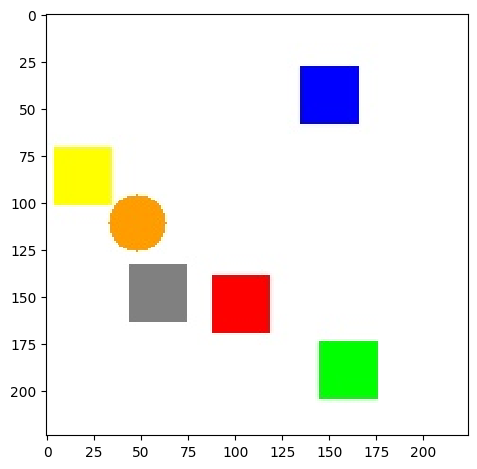

In [ ]:
img2 = cv2.imread('data/train/images/3.jpg')
imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [ ]:
nsai.executor.scene = nsai.perceiver.scene_repr(img2)
nsai.executor.scene

/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scene_df = scene_df.append({'shape': shape,
/home/shr/Documents/projects/nsvqa/perception.py:208: FutureWarning:

,shape,color,position
0,rectangle,green,"(159, 188)"
1,rectangle,red,"(103, 152)"
2,rectangle,yellow,"(19, 84)"
3,rectangle,blue,"(151, 44)"
4,rectangle,gray,"(59, 148)"
5,circle,orange,"(47, 112)"


In [ ]:
program = nsai.sem_parser.predict('How many objects of same shape of green colour object?')
program

['filter green', 'query shape', 'filter', 'count']

In [ ]:
string=''
for i in program:
    if len(i.split(' ')) == 2:
        string = string

In [ ]:
nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('green'), 'shape')))

5

In [ ]:
nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('orange'), 'shape')))

2

In [ ]:
nsai.executor.query(nsai.executor.relate(nsai.executor.filter_('green'), 'furthest'), 'shape')

'circle'